# Fully Connected Neural Networks

The code below is for compatibility with Python 2. If you are using Python 3 (recommended), you may ignore this.

In [1]:
from __future__ import division
from __future__ import print_function

Here, we import various Python packages that we will be using: TensorFlow (aliased as tf) for creating neural networks, NumPy (aliased as np) for general numeric operations, and MatPlotLib's PyPlot (aliased as plt) for plotting.

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Loading MNIST dataset

The MNIST dataset is a commonly-used dataset for handwritten digit recognition, and is a mix of writing taken from American Census Bureau employees and US high school students. The dataset has been preprocessed so that each image is 28x28 pixels. Current state of the art achieves around 99.8% accuracy (certain samples are illegible even to people).

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('../data/', one_hot=True)

Extracting ../data/train-images-idx3-ubyte.gz
Extracting ../data/train-labels-idx1-ubyte.gz
Extracting ../data/t10k-images-idx3-ubyte.gz
Extracting ../data/t10k-labels-idx1-ubyte.gz


How is the training set formatted? Hint: the images are 28x28

In [5]:
mnist.train.images.shape

(55000, 784)

In [6]:
def plot_digits(*args):
    indices = np.array(list(args))
    n = len(indices)
    fig, axes =  plt.subplots(ncols=n, figsize=(n, 1))
    for i in range(n):
        ax = axes.flatten()[i]
        img = mnist.train.images[indices[i]].reshape(28, 28)
        label = np.argmax(mnist.train.labels[indices[i]])
        ax.set_title('Label: {}'.format(label))
        ax.imshow(img, cmap='gray')
        ax.axis('off')
    plt.show()

Pick some random numbers between 0 and 44999 (remember that list/arrays in Python are 0-indexed!) to see what the images look like. Can you find some outliers that are difficult even for humans?

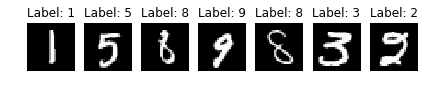

In [7]:
plot_digits(12, 28, 42, 558, 78, 12333, 13)

Recall that for a machine learning algorithm to work, we need **labelled** data: here, the labels represent the digit that the image actually corresponds to. How is this data stored?

In [8]:
mnist.train.labels.shape

(55000, 10)

Here are the first 5 labels - what is the format that is being used?

In [9]:
mnist.train.labels[:5]

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

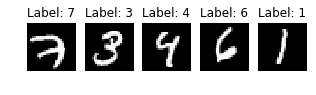

In [10]:
plot_digits(0, 1, 2, 3, 4)

One-hot encoding is a key concept when dealing with categorical variables, and there are many interpretations. One is that if we were to store the actual number represented, what do we do if our model predicts a value of 3.5? As far as writing digits goes, there is no such thing as something halfway between a 3 and a 4. In addition, it makes no sense to say that the difference between a 2 and 6 is 4 times as large as the difference between a 2 and 3. Another interpretation is that the one-hot encoding represents a probability distrbution: each digit is a possible answer that is disjoint from all others - the labels represent our 100% confidence in what we know the answer to be. 

In [11]:
x_train = mnist.train.images
y_train = mnist.train.labels

x_test = mnist.test.images
y_test = mnist.test.labels

The dataset has been split into training and test sets at a 5.5:1 ratio. It is common practice to reserve 10-30% of the data as test data.

In [12]:
print(x_train.shape)
print(x_test.shape)

(55000, 784)
(10000, 784)


## Creating a Fully Connected Neural Network

To make things easier, we create two helper functions that will create the weights and biases for each layer. Notice that we use `tf.variable_scope()` and `tf.get_variable()` instead of `tf.Variable()`. We use `tf.variable_scope()` to group together all the tensors and variables we define inside it. This does a couple of nice things:

- Anything we define inside the variable scope will have its name prefixed with the name of the scope
- If we try to display the graph, it will look much more organized (remember the tensorflow tutorial?)
- We can control whether we reuse variables or not (more on that in a few sentences)

Using `tf.get_variable()` will create a `tf.Variable` if the variable does not exist yet. If the variable already exists and the variable scope is in reuse mode, it will return the original variable without creating a new one. If not in reuse mode, it will throw an error, preventing us from accidentally duplicating variables
For these reasons using `tf.variable_scope()` is a great organizational tool and helps us avoid making mistakes by preventing accidental variable duplication. If we had used `tf.Variable()`, it would ignore these duplication rules and always make a new variable, adding a suffix onto the name if it already existed.

**In summary: Always keep your code organized and safe from sneaky bugs by using `tf.variable_scope()`, and use `tf.get_variable()` instead of `tf.Variable()`.**

In [13]:
def weight_variable(shape):
    w_init = tf.truncated_normal(shape, stddev=0.01)
    return tf.get_variable('w', initializer=w_init)


def bias_variable(shape):
    b_init = tf.constant(0.0, shape=shape)
    return tf.get_variable('b', initializer=b_init)

In [14]:
with tf.variable_scope('inputs'):
    x = tf.placeholder(tf.float32, [None, 784])
    y = tf.placeholder(tf.float32, [None, 10])

with tf.variable_scope('fc1'):
    W_fc1 = weight_variable([784, 1200])
    b_fc1 = bias_variable([1200])
    h_fc1 = tf.nn.relu(tf.matmul(x, W_fc1) + b_fc1)

with tf.variable_scope('fc2'):
    W_fc2 = weight_variable([1200, 1200])
    b_fc2 = bias_variable([1200])
    h_fc2 = tf.nn.relu(tf.matmul(h_fc1, W_fc2) + b_fc2)

with tf.variable_scope('softmax'):
    W_fc3 = weight_variable([1200, 10])
    b_fc3 = bias_variable([10])
    preds = tf.nn.softmax(tf.matmul(h_fc2, W_fc3) + b_fc3)

In [15]:
with tf.variable_scope('optimization'):
    # define the loss function
    cross_entropy = tf.reduce_mean(-tf.reduce_sum(y * tf.log(preds), reduction_indices=[1]))
    
    # define training step and accuracy
    train_step = tf.train.AdamOptimizer(learning_rate=0.00001).minimize(cross_entropy)
    correct = tf.equal(tf.argmax(preds, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [16]:
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(init)

In [ ]:
n_epochs = 1000
batch_size = 16

## Training the Network

Now we just need to feed the training set into the model and perform gradient descent. Because the training set is large (55000 images), we will feed in only a subset of the training set at a time for each batch.

**NOTE:** This will take a while... (15+ mins)

In [ ]:
for n in range(n_epochs):
    permutation = np.random.permutation(x_train.shape[0])
    for i in range(0, x_train.shape[0], batch_size):
        idx = permutation[i: i + batch_size]
        x_batch = x_train[idx]
        y_batch = y_train[idx]
        sess.run(train_step, feed_dict={x: x_batch, y: y_batch})

        loss, acc = sess.run([cross_entropy, accuracy], 
                             feed_dict={x: x_train, y: y_train})
        
        print('epoch {:2d} step {:4d} loss={:.3f} accuracy={:.2f}%'
              .format(n, int(i/batch_size)+1, loss, 100*acc))

## Load Pre-trained Model

Since training a model from scratch takes time, we have uploaded a saved model in the `models` folder of the root directory of this repository.

In [17]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
saver = tf.train.import_meta_graph('../models/fcn/mnist_fc.meta')
saver.restore(sess, tf.train.latest_checkpoint('../models/fcn'))
x = tf.get_default_graph().get_tensor_by_name('inputs/Placeholder:0')
preds = tf.get_default_graph().get_tensor_by_name('softmax/Softmax:0')
p1 = tf.get_default_graph().get_tensor_by_name('inputs/Placeholder_2:0')
p2 = tf.get_default_graph().get_tensor_by_name('fc1/Placeholder:0')

INFO:tensorflow:Restoring parameters from ../models/fcn/mnist_fc


In [18]:
def plot_predictions(*args):
    indices = np.array(list(args))
    n = len(indices)
    fig, axes =  plt.subplots(ncols=n, figsize=(n, 1))
    for i, idx in enumerate(indices):
        ax = axes.flatten()[i]
        vec = mnist.test.images[idx]
        img = vec.reshape(28, 28)
        args = {x: np.expand_dims(vec, 0), p1: 1.0, p2: 1.0}
        pred = sess.run(preds, feed_dict=args)
        ax.set_title('Pred: {}'.format(np.argmax(pred)))
        ax.imshow(img, cmap='gray')
        ax.axis('off')
    plt.show()

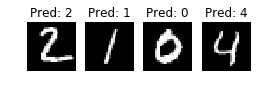

In [19]:
plot_predictions(1, 2, 3, 4)